# Simulate Sequences

In [1]:
### IMPORTS
from simulate import run_simulation

### Run Single Simulation
Commented out, uncomment to use.

In [2]:
# Number of unique monomers
N_MONs = 4

# Molar ratios of each monomer
# ex. if N_MONs = 4: [0.5, 0.25, 0.20, 0.05]
MRs = [50, 25, 20, 5]

# What model of copolymerization to use? (1) mayolewis (terminal) or (2) penultimate
# NOTE FOR NOW ONLY MAYO-LEWIS IMPLEMENTED.
#model = "mayolewis"

# reactivity ratios of monomers, ex. for 4 monomers:
#[r12, r13, r14]
#[r21, r23, r24]
#[r31, r32, r34]
#[r41, r42, r43]
RRs = ([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])

# % conversion targetted (0-1), i.e. how much of the monomer pool do you want to use
conv = 0.5

# average degree of polymerization (chain length) you are targetting at YOUR conversion, NOT at 100%.
avgDP = 100

# number of polymer chains to simulate
N_CHAINs = 10000

# Chain transfer % (0-1)
# TODO: replace this with direct PDI control (not sure how)
# NOTE TO SELF: for now just fix CTP such that PDI ~ 1.2, as thats roughly the control our RAFT synthesis gives.
CTP = 0.05

# cutoff DP of chains considered as polymers not oligomers that get "purified" out
# set to 0 if you don't want to do any filtration
PRUNE_OLIGOMERS = 25

In [ ]:
# UNCOMMENT TO USE THIS CODE:
# run_simulation(N_MONs, N_CHAINs, MRs, RRs, avgDP, conv, CTP, PRUNE_OLIGOMERS)

### Run Multiple Simulations

Currently, various DPs are simulated - this can/should be changed to vary other things too, as well as instead of just simulating 4, a linspace between a max and min specifying the number of sample points.

In [3]:
# Number of unique monomers
N_MONs = 4

# Molar ratios of each monomer
# ex. if N_MONs = 4: [0.5, 0.25, 0.20, 0.05]
MRs = [50, 25, 20, 5]

# reactivity ratios of monomers, ex. for 4 monomers:
#[r12, r13, r14]
#[r21, r23, r24]
#[r31, r32, r34]
#[r41, r42, r43]
RRs = ([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])

# % conversion targetted (0-1), i.e. how much of the monomer pool do you want to use
conv = 0.5

# average degree of polymerization (chain length) you are targetting at YOUR conversion, NOT at 100%.
avgDPs = [50, 75, 100, 125, 150, 175, 200, 225, 250]

# number of polymer chains to simulate
N_CHAINs = 10000

# Chain transfer % (0-1)
# TODO: replace this with direct PDI control (not sure how)
# NOTE TO SELF: for now just fix CTP such that PDI ~ 1.2, as thats roughly the control our RAFT synthesis gives.
CTP = 0.1

# cutoff DP of chains considered as polymers not oligomers that get "purified" out
# set to 0 if you don't want to do any filtration
PRUNE_OLIGOMERS = 25

In [4]:
for avgDP in avgDPs:
    run_simulation(N_MONs, N_CHAINs, MRs, RRs, avgDP, conv, CTP, PRUNE_OLIGOMERS)

Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP50_conv50_CTP10_FILT25.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP75_conv50_CTP10_FILT25.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP100_conv50_CTP10_FILT25.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP125_conv50_CTP10_FILT25.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP150_conv50_CTP10_FILT25.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP175_conv50_CTP10_FILT25.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP200_conv50_CTP10_FILT25.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP225_conv50_CTP10_FILT25.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP250_conv50_CTP10_FILT25.csv


# Seq Analysis

In [5]:
import pandas as pd
import numpy as np
import glob, os
import csv
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import copy
import csv
from tqdm import tqdm_notebook
from itertools import tee

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 35

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Load sequence CSV files and set monomer properties
Specify path and what monomers each label corresponds to here (by specifying Mw and HLB)

In [6]:
### IMPORT ALL SEQUENCE CSV FILES IN FOLDER SPECIFIED BY PATH

path = "outputs"
csv_files = []
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_files.append(os.path.join(path, file))
csv_files = sorted(csv_files)
print("Number of sequence files:", len(csv_files))
print(csv_files)

### SET MOLECULAR WEIGHTS OF MONOMERS IN ORDER OF LABEL (labels are 1 indexed)
Mw = [100.121,500,198.3,246.32]
HLBs = [8.45, 11.42, 5.125, 18.5]

Number of sequence files: 9
['outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP100_conv50_CTP10_FILT25.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP125_conv50_CTP10_FILT25.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP150_conv50_CTP10_FILT25.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP175_conv50_CTP10_FILT25.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP200_conv50_CTP10_FILT25.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP225_conv50_CTP10_FILT25.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP250_conv50_CTP10_FILT25.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP50_conv50_CTP10_FILT25.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP75_conv50_CTP10_FILT25.csv']


### Calculate general sequence statistics and average properties for all sequences by batch
Output is a dataframe with column headers: [Batch Name	NumSeqs	Avg Mn	Avg Mw	PDI	Avg DP]

In [7]:
### CALCULATE AVERAGE DP, Mn, Mw & PDI OF ALL SEQUENCES

names = []
num_seqs = []
avg_Mns = []
avg_Mws = []
PDIs = []
avg_DPs = []
seqs = []

for m in tqdm_notebook(range(len(csv_files))):
    seq = []

    with open(csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            seq.append(lines)
    raw_seq = copy.deepcopy(seq)
    seqs.append(raw_seq)
    seqlen = np.zeros(i)
    seqweight = np.zeros(i)
    seqweight2 = np.zeros(i)

    for j in range(0,i):
        seqlen[j] = len(seq[j])
        for k in range(len(seq[j])):
            seq[j][k] = Mw[int(seq[j][k])-1]
        seqweight[j] = sum(seq[j])
        seqweight2[j] = (sum(seq[j])**2)

    AvgMw = sum(seqweight2)/sum(seqweight)
    AvgMn = sum(seqweight)/len(seqweight)
    PDI = AvgMw/AvgMn
    DP = sum(seqlen)/len(seqlen)

    names.append(csv_files[m].replace(path, '').replace('/', '').replace('.csv', ''))
    num_seqs.append(i)
    avg_Mns.append(AvgMn)
    avg_Mws.append(AvgMw)
    PDIs.append(PDI)
    avg_DPs.append(DP)
    
d = {'Batch Name': names, 'NumSeqs': num_seqs, 'Avg Mn': avg_Mns, 'Avg Mw': avg_Mws, 'PDI': PDIs, 'Avg DP': avg_DPs}
df_prop = pd.DataFrame(data=d)
df_prop

,Batch Name,NumSeqs,Avg Mn,Avg Mw,PDI,Avg DP
0,"NM4_MR[50, 25, 20, 5]_NC10000_DP100_conv50_CTP...",9865,22962.376629,26999.465808,1.175813,101.129549
1,"NM4_MR[50, 25, 20, 5]_NC10000_DP125_conv50_CTP...",9978,28453.498714,32726.711850,1.150182,125.234015
2,"NM4_MR[50, 25, 20, 5]_NC10000_DP150_conv50_CTP...",9994,34075.912757,38497.701808,1.129763,150.077146
3,"NM4_MR[50, 25, 20, 5]_NC10000_DP175_conv50_CTP...",9999,39722.630706,44101.203805,1.110229,175.015002
4,"NM4_MR[50, 25, 20, 5]_NC10000_DP200_conv50_CTP...",10000,45401.763118,49860.699220,1.098211,200.000000
5,"NM4_MR[50, 25, 20, 5]_NC10000_DP225_conv50_CTP...",9999,51097.200147,55531.487756,1.086781,225.021302
6,"NM4_MR[50, 25, 20, 5]_NC10000_DP250_conv50_CTP...",10000,56777.985615,61097.945719,1.076085,250.000000
7,"NM4_MR[50, 25, 20, 5]_NC10000_DP50_conv50_CTP1...",7698,13711.774805,16695.653505,1.217614,60.394778
8,"NM4_MR[50, 25, 20, 5]_NC10000_DP75_conv50_CTP1...",9357,17936.029083,21656.971373,1.207456,78.975633


In [8]:
#Read csv output files of 'n' batches and convert to n-element pd dataframe
dfs = []
seq_lens = []

for m in range(len(csv_files)):
    seq = []
    row_size = []
    
    with open(csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            seq.append(lines)
            row_size.append(len(lines))
        df = pd.DataFrame(seq)
        dfs.append(df)
        seq_lens.append(row_size)

dfs[0].head()

### Composition Heterogeneity
- mon2mon: visualize sequences simulated (TODO: make this prettier - get code from adv. attack notebook)
- seq2seq: Plot histogram with KDE fit of composition variance per chain around feeding fraction
- batch2batch: nFWHM to compare histograms between batches (normalized full width half maximum: (FWHM = 2*sqrt(2*ln(2))* stdev ~= 2.355*stdev ) & FWHM normalized by feeding fraction)

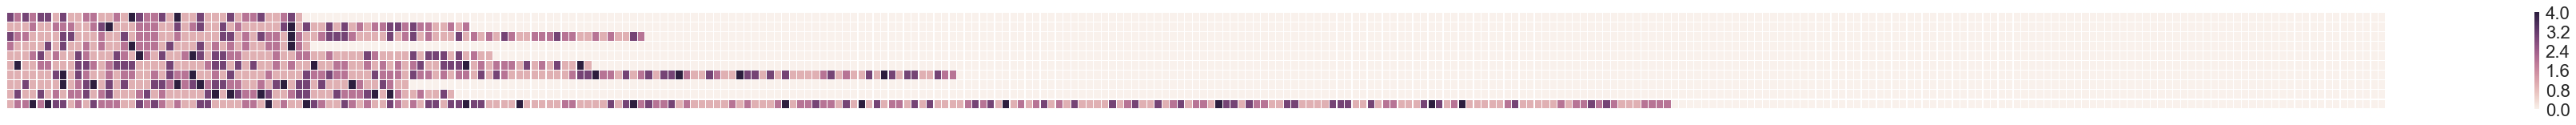

In [122]:
### VISUALIZE SEQUENCE SIMULATED
batch_no = 0
seq_no = 0
num_seqs = 10

chains = []
for i in range(num_seqs):
    chains.append([int(x) if x != None else 0 for x in dfs[batch_no].iloc[seq_no + i]])

plt.figure(num=None, figsize=(60, 2), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(chains, vmin=0, vmax=N_MONs, linewidth=0.2, xticklabels=False, yticklabels=False)
plt.show()
plt.cla()   # Clear axis
plt.clf()   # Clear figure

NM4_MR[50, 25, 20, 5]_NC10000_DP100_conv50_CTP10_FILT25
[0.12884405 0.11138293 0.10346416 0.05618015]
[0.25779698 0.44486135 0.51791293 1.12218679]


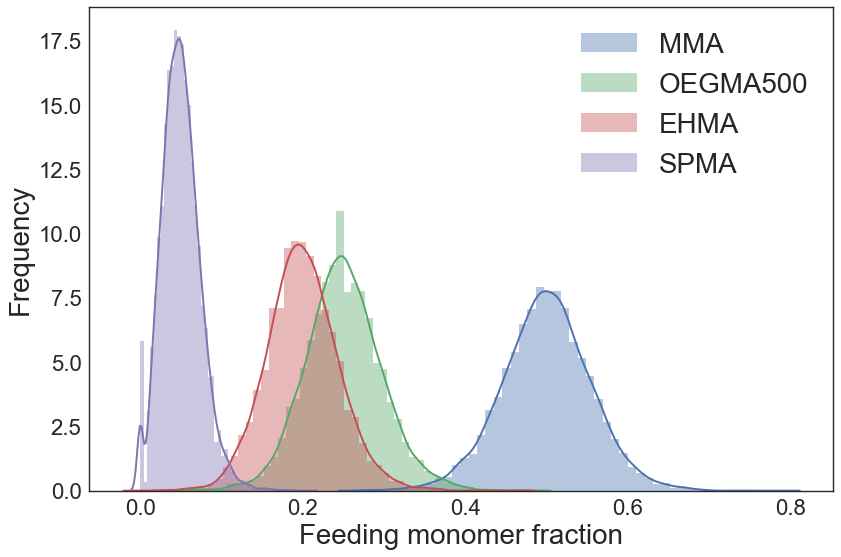

NM4_MR[50, 25, 20, 5]_NC10000_DP125_conv50_CTP10_FILT25
[0.1138247  0.09861274 0.09227951 0.04969381]
[0.22762026 0.39375015 0.46224598 0.99670398]


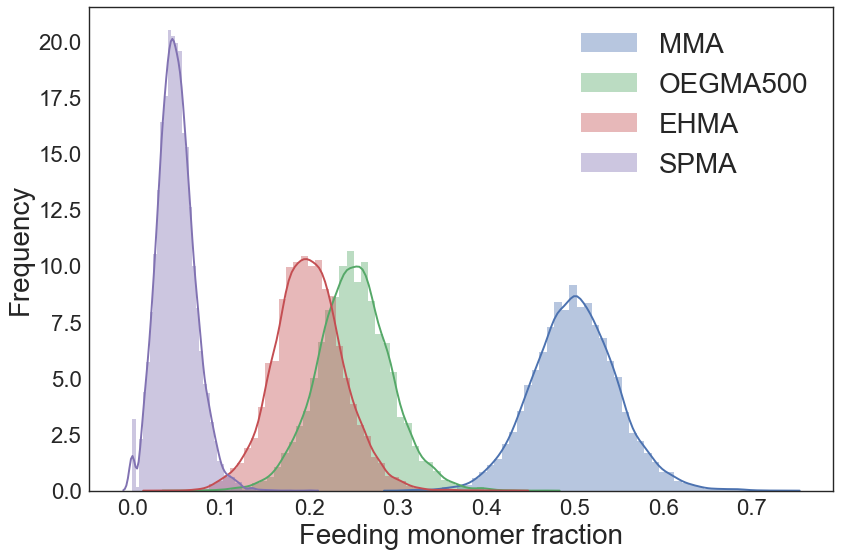

NM4_MR[50, 25, 20, 5]_NC10000_DP150_conv50_CTP10_FILT25
[0.10193273 0.08891493 0.08230465 0.04508041]
[0.20397825 0.35573991 0.41147657 0.89604987]


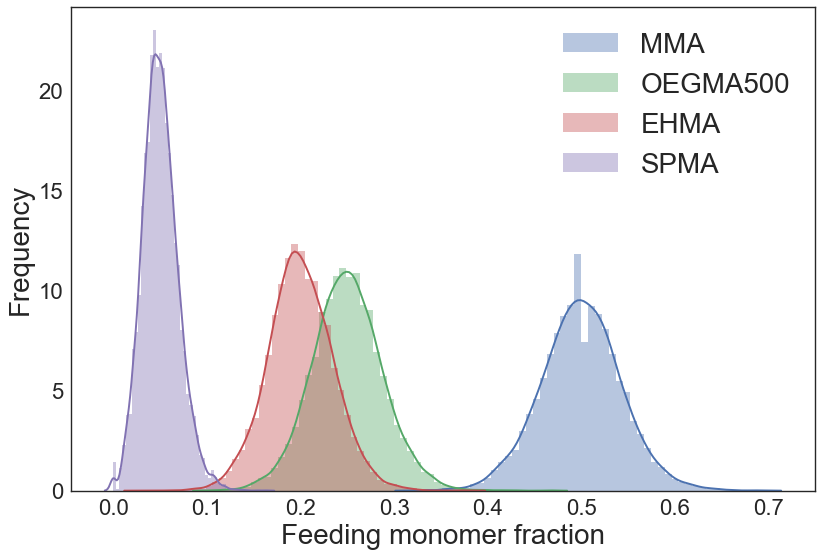

NM4_MR[50, 25, 20, 5]_NC10000_DP175_conv50_CTP10_FILT25
[0.09461298 0.08203643 0.07629684 0.04103406]
[0.18914461 0.32853317 0.3810896  0.82277631]


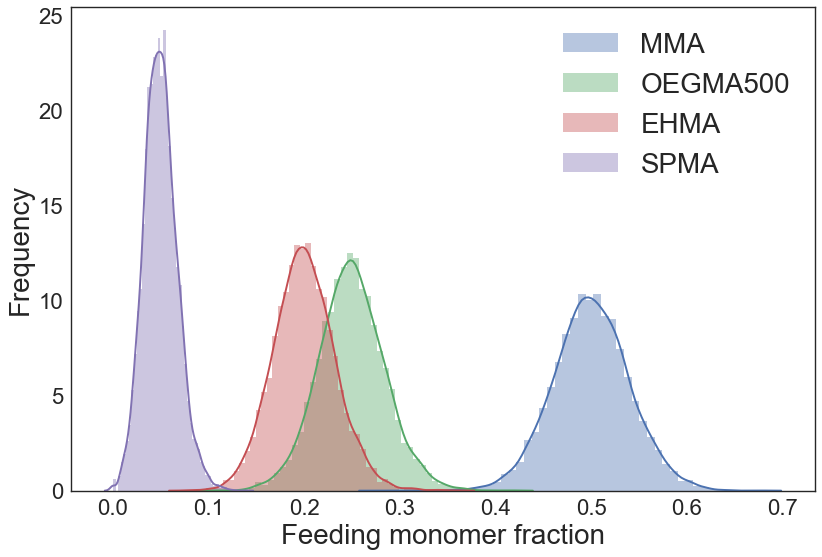

NM4_MR[50, 25, 20, 5]_NC10000_DP200_conv50_CTP10_FILT25
[0.08802196 0.07536883 0.07030919 0.03820567]
[0.17602176 0.30168176 0.35138376 0.76387197]


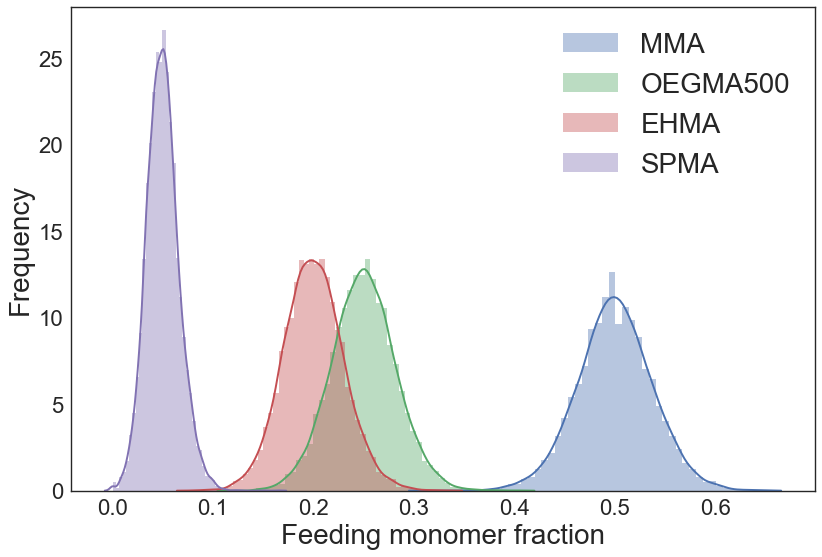

NM4_MR[50, 25, 20, 5]_NC10000_DP225_conv50_CTP10_FILT25
[0.0818054  0.07167543 0.06570772 0.03593375]
[0.16362477 0.28648772 0.3286484  0.71978661]


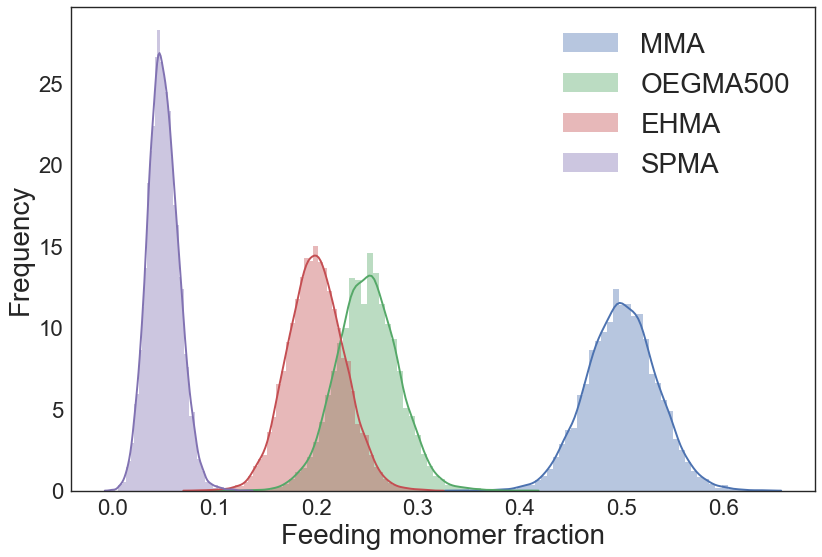

NM4_MR[50, 25, 20, 5]_NC10000_DP250_conv50_CTP10_FILT25
[0.07705284 0.06722702 0.06190962 0.0336344 ]
[0.15419697 0.26870935 0.30917096 0.67447995]


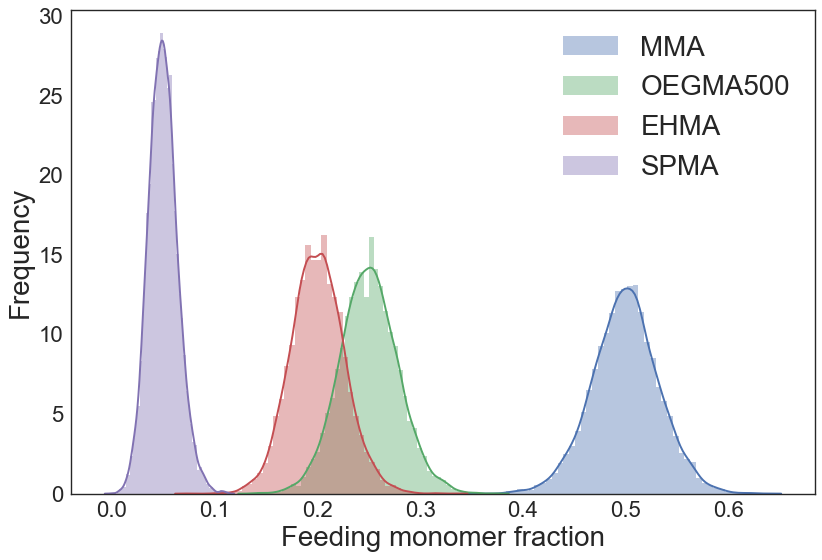

NM4_MR[50, 25, 20, 5]_NC10000_DP50_conv50_CTP10_FILT25
[0.16677337 0.14354298 0.13273041 0.07289133]
[0.33353202 0.57426587 0.66380118 1.45596963]


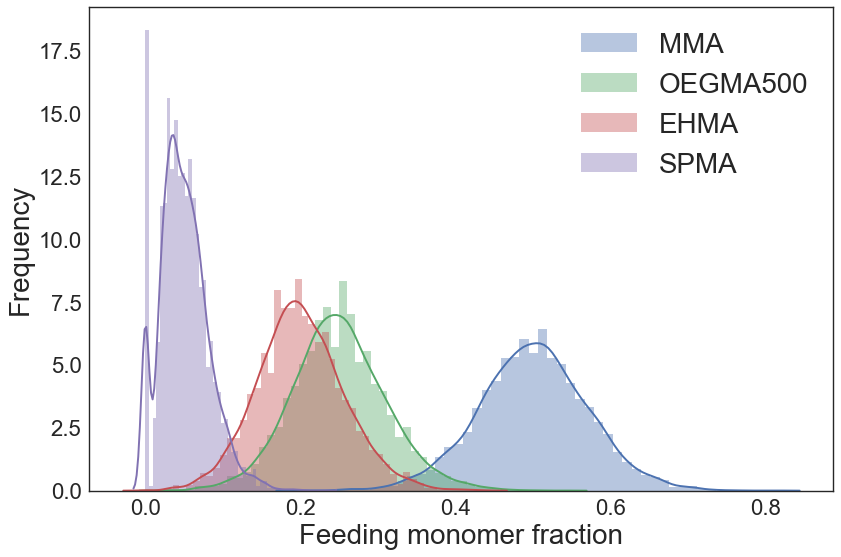

NM4_MR[50, 25, 20, 5]_NC10000_DP75_conv50_CTP10_FILT25
[0.14786734 0.12814557 0.11819323 0.06415751]
[0.29590146 0.51169342 0.59029798 1.29294697]


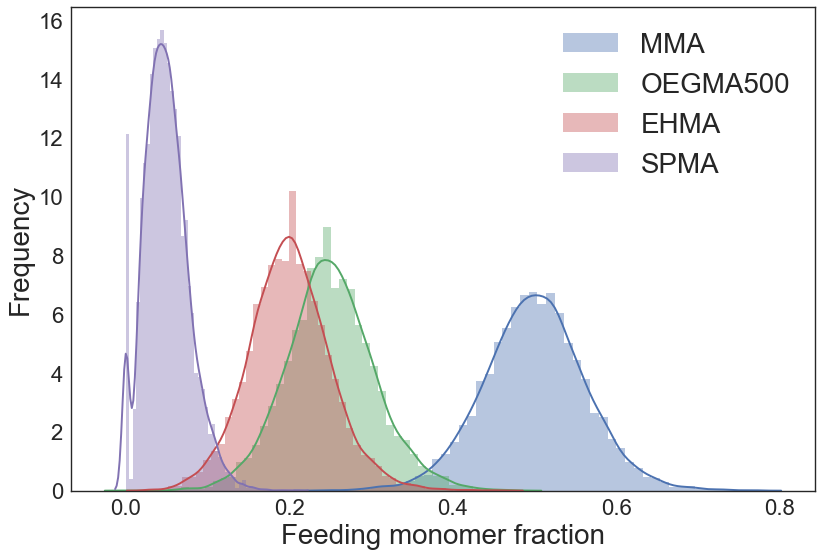

In [37]:
### Histograms of composition on each individual monomer chain:

N_MONS = 4 # number of unique monomers
RUN_ONLY_SUBSET = False # set False if you want to run all sequences

FWHMs = []
FWHM_norms = []

for m in range(len(csv_files)):
    seq = []
    
    if RUN_ONLY_SUBSET:
        if m not in subset_inds:
            continue
    
    with open(csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            seq.append(lines)
            #print(lines)

    seqlen = np.zeros(i)
    seq_comp = np.zeros([i,4])

    for j in range(0,i):
        seqlen[j] = len(seq[j])
        for k in range(4):
            seq_comp[j][k] = seq[j].count(str(k+1))/seqlen[j]
            
    print(csv_files[m].replace(path, '').replace('/', '').replace('.csv', ''))
    FWHM = np.zeros(N_MONS)
    FWHM_norm = np.zeros(N_MONS)
    for i in range(N_MONS):
        #MMA_x, MMA_y = sns.distplot(seq_comp[:,0], label="MMA").get_lines()[0].get_data()
        FWHM[i] = 2.355*np.std(seq_comp[:,i])
        FWHM_norm[i] = 2.355*np.std(seq_comp[:,i])/np.mean(seq_comp[:,i])
    print(FWHM)
    print(FWHM_norm)
    FWHMs.append(FWHM)
    FWHM_norms.append(FWHM_norm)

    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    sns.set_style(style='white') #style='white' or 'darkgrid'
    plt.xlabel("Feeding monomer fraction")
    plt.ylabel("Frequency")
    sns.distplot(seq_comp[:,0], label="MMA")
    sns.distplot(seq_comp[:,1], label="OEGMA500")
    sns.distplot(seq_comp[:,2], label="EHMA")
    sns.distplot(seq_comp[:,3], label="SPMA")
    plt.legend()
    plt.show()

    plt.cla()   # Clear axis
    plt.clf()   # Clear figure

    """ # (same plot but using plt instead of sns)
    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel("chain composition fraction", fontsize=15)
    #plt.ylabel("asdf")
    plt.hist(seq_comp[:,0], label="MMA")
    plt.hist(seq_comp[:,1], label="OEGMA500")
    plt.hist(seq_comp[:,2], label="EHMA")
    plt.hist(seq_comp[:,3], label="SPMA")
    plt.legend(fontsize=15)
    plt.show()
    """

FWHMs = np.array(FWHMs)
FWHM_norms = np.array(FWHM_norms)

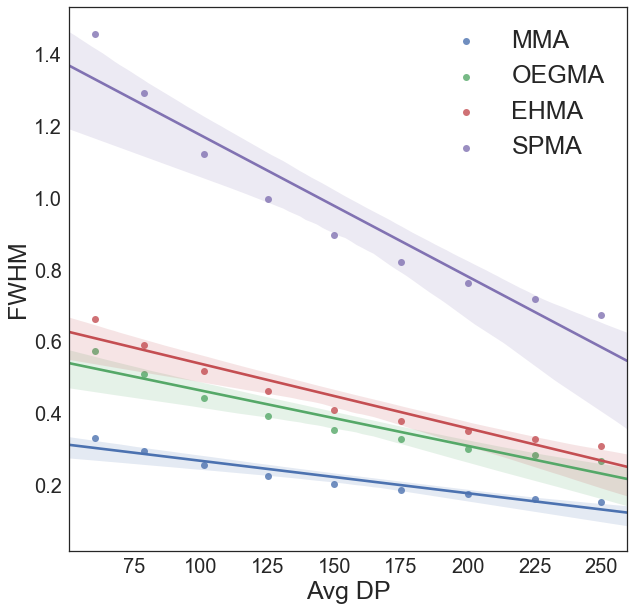

In [38]:
for i in range(4):
    df_prop['FWHM_' + str(i)] = FWHM_norms[:,i]
    
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.set_style(style='white') #style='white' or 'darkgrid'
ax = sns.regplot(x="Avg DP", y="FWHM_0", data=df_prop, label='MMA')
ax = sns.regplot(x="Avg DP", y="FWHM_1", data=df_prop, label='OEGMA')
ax = sns.regplot(x="Avg DP", y="FWHM_2", data=df_prop, label='EHMA') 
ax = sns.regplot(x="Avg DP", y="FWHM_3", data=df_prop, label='SPMA')
ax.set_ylabel('FWHM')
#ax.set(ylim=(0, 1))
plt.legend(loc='best')
plt.show()

### Hydrophilic & Hydrophobic Segments
- mon2mon: Visualize hydrophobic & hydrophilic segments along a chain?
- seq2seq: box-whisker of avg'd per chain proerties and batch summed statistics (histogram)
- batch2batch: (TODO) plot multiple histograms either on the same plot/axes with seethrough/opaque bars cuz they’ll be overlapping —> just have a bold line of best fit overlaying the top of the histogram —> replace with sns.distplot like we did for the composition histograms.

In [139]:
# EXTRA PARAM: determines what is considered hydrophobic and what is considered hydrophilic
# Anything less than or equal to HLB_CUTOFF is considered hydrophobic.
HLB_CUTOFF = 9

rows size: 9865
cols size: 313


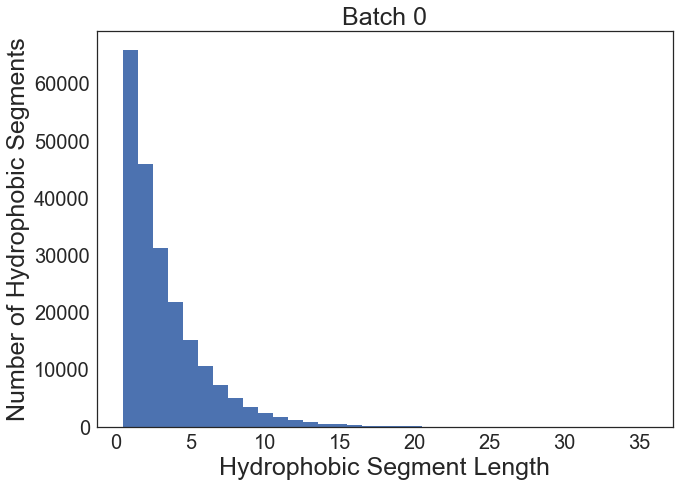

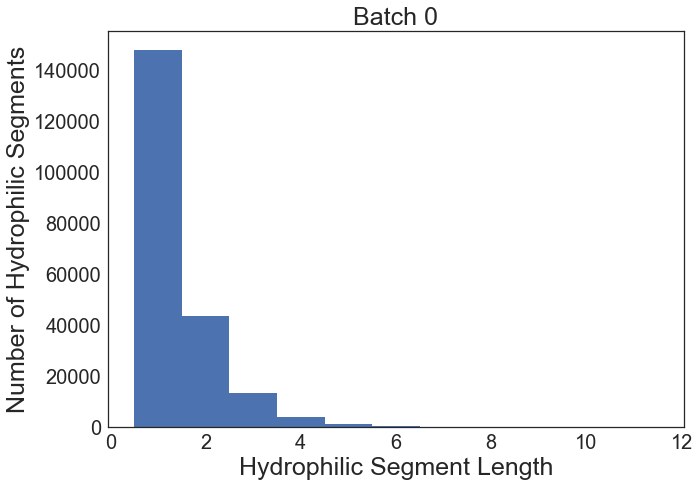

AttributeError: module 'seaborn' has no attribute 'lineplot'

In [197]:
# BATCH SUMMED STATISTICS FOR
for batch_ind in tqdm_notebook(range(len(hlb_csv_files))):

    rows_size = len(dfs[batch_ind])
    print("rows size:", rows_size)
    cols_size = len(dfs[batch_ind].columns)
    print("cols size:", cols_size)
    
    # count the hydrophilic and hydrophobic segments
    hydrophob_li = list()
    hydrophil_li = list()
    for i in tqdm_notebook(range(rows_size)):
        hydrophobl = np.zeros(cols_size)
        hydrophilbl = np.zeros(cols_size)
        counterpho = 0
        counterphil = 0
        for j in range(cols_size):
            if dfs[batch_ind][j][i] == None:
                if counterpho > 0:
                    hydrophobl[counterpho-1] += 1
                if counterphil > 0:
                    hydrophilbl[counterphil-1] += 1
                break
            elif HLBs[int(dfs[batch_ind][j][i])-1] <= HLB_CUTOFF:
                counterpho += 1
                if counterphil > 0:
                    hydrophilbl[counterphil-1] += 1
                counterphil = 0
                continue
            else:
                counterphil += 1
                if counterpho > 0:
                    hydrophobl[counterpho-1] += 1
                counterpho = 0
                continue

        hydrophob_li.append(hydrophobl)
        hydrophil_li.append(hydrophilbl)

    hydrophobic_df = pd.DataFrame(hydrophob_li)
    hydrophilic_df = pd.DataFrame(hydrophil_li)

    # Sum the segment counts
    graph1_phob = np.array(hydrophobic_df.sum(axis=0))
    graph1_phil = np.array(hydrophilic_df.sum(axis=0))

    # go backwards from both until you find the first non-zero entry and truncate there
    for i in range(1,len(graph1_phob)):
        if (graph1_phob[-i] != 0.0):
            graph1_phob = graph1_phob[:(-i+1)]
            break

    for i in range(1,len(graph1_phil)):
        if (graph1_phil[-i] != 0.0):
            graph1_phil = graph1_phil[:(-i+1)]
            break

            
    # create x-axis for both
    x_phob_1 = np.arange(1,len(graph1_phob)+1)
    x_phil_1 = np.arange(1,len(graph1_phil)+1)
    
    
    # PLOT hydrophobic & hydrophilic segments
    plt.cla()   # Clear axis
    plt.clf()   # Clear figure
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x_phob_1,graph1_phob, width = 1)
    plt.xlabel("Hydrophobic Segment Length")
    plt.ylabel("Number of Hydrophobic Segments")

    plt.title("Batch " + str(batch_ind))
    plt.show()
    plt.cla()   # Clear axis
    plt.clf()   # Clear figure

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x_phil_1,graph1_phil, width = 1)
    plt.xlabel("Hydrophilic Segment Length")
    plt.ylabel("Number of Hydrophilic Segments")

    plt.title("Batch " + str(batch_ind))
    plt.show()
    plt.cla()   # Clear axis
    plt.clf()   # Clear figure
    
    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    sns.set_style(style='white') #style='white' or 'darkgrid'
    plt.xlabel("Segment Length")
    plt.ylabel("Counts")
    sns.lineplot(x_phob_1, graph1_phob, label="hydrophobic")
    plt.legend()
    plt.show()
    plt.cla()   # Clear axis
    plt.clf()   # Clear figure


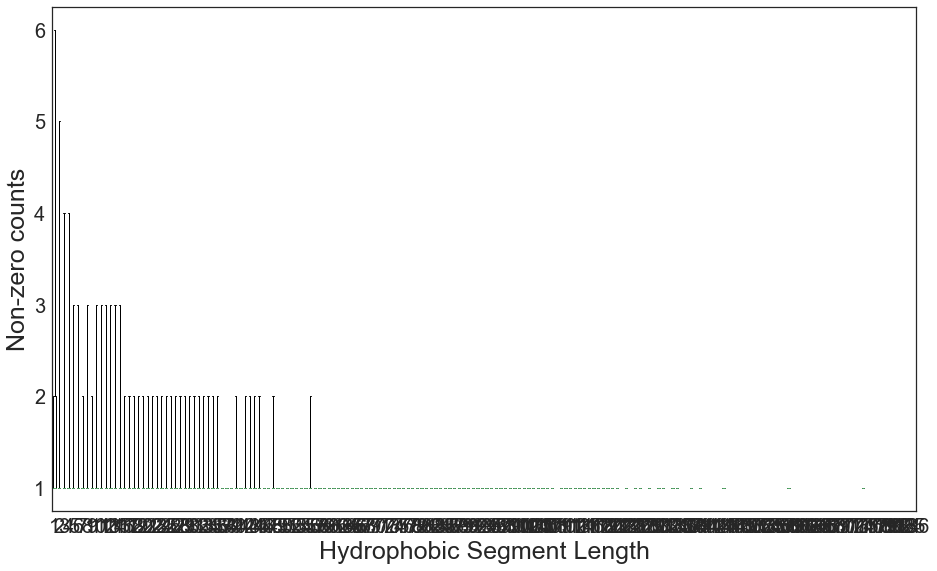

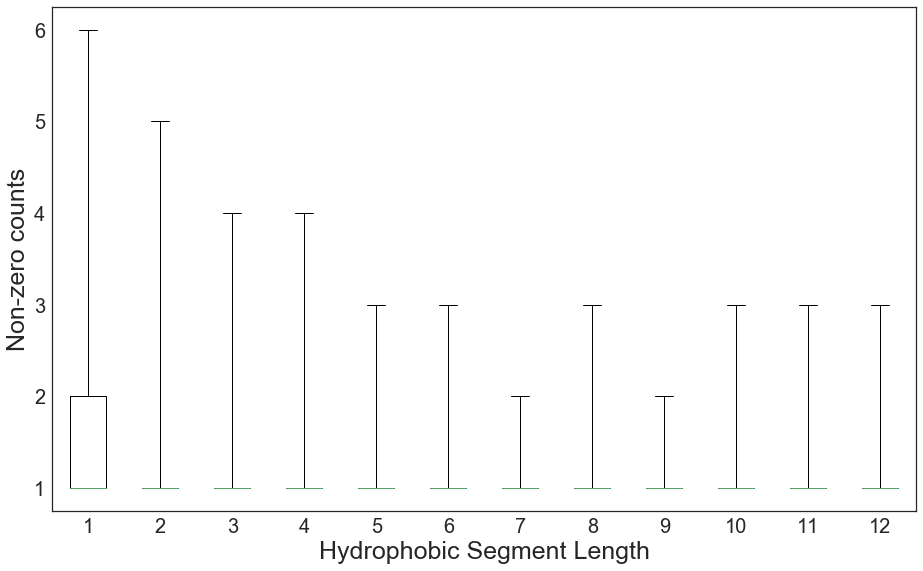

In [22]:
### FULL HYDROPHOBIC DATASET (non-zero)
phobic_length_data = []
for i in range(len(graph1_phob)):
    phobic_length_data.append([ y_ for y_ in list(hydrophobic_df[i]) if y_ != 0.0])
        
fig = plt.figure(figsize =(12, 7))
#ax = fig.add_axes([0, 1, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(phobic_length_data, whis=(0,100))
plt.xlabel("Hydrophobic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
plt.show()

#  just hydrophobic segment lengths up to 10
phobic_length_data2 = []
for i in range(12):
    phobic_length_data2.append([ y_ for y_ in list(hydrophobic_df[i]) if y_ != 0.0])

fig = plt.figure(figsize =(12, 7))
#ax2 = fig.add_axes([0, 0, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(phobic_length_data2, whis=(0,100))
plt.xlabel("Hydrophobic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
plt.show()

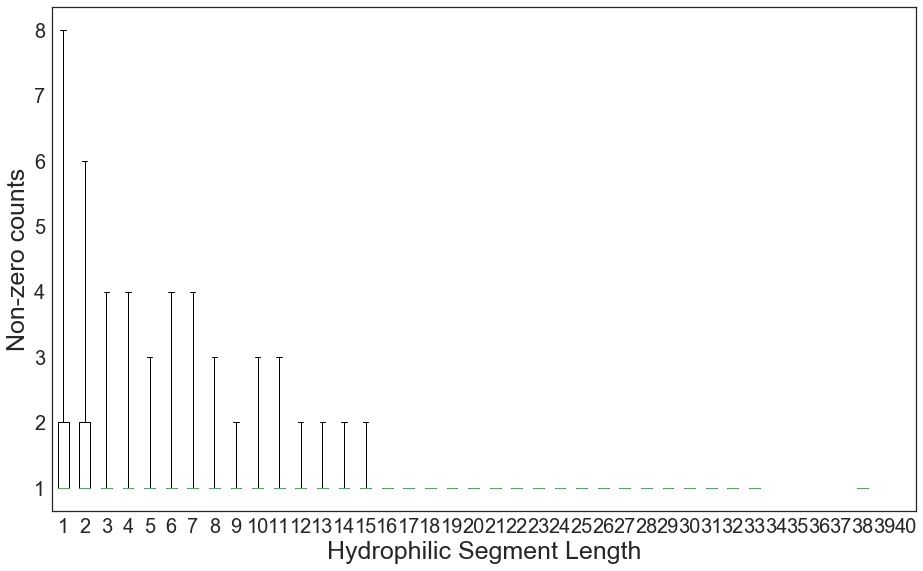

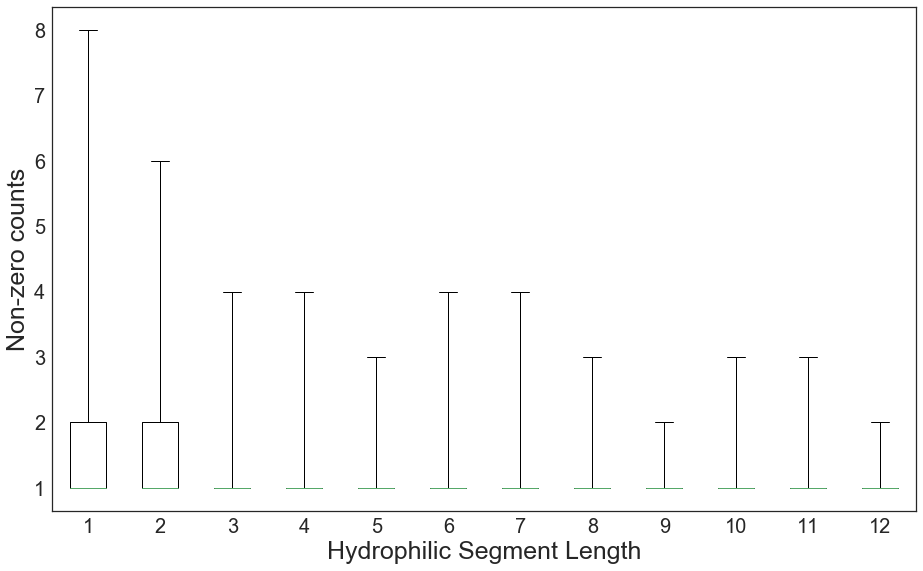

In [23]:
### FULL HYDROphilic DATASET (non-zero)
philic_length_data = []
for i in range(len(graph1_phil)):
    philic_length_data.append([ y_ for y_ in list(hydrophilic_df[i]) if y_ != 0.0])
        
fig = plt.figure(figsize =(12, 7))
#ax = fig.add_axes([0, 1, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(philic_length_data, whis=(0,100))
plt.xlabel("Hydrophilic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks

#  just hydrophilic segment lengths up to 10
philic_length_data2 = []
for i in range(12):
    philic_length_data2.append([ y_ for y_ in list(hydrophilic_df[i]) if y_ != 0.0])

fig = plt.figure(figsize =(12, 7))
#ax2 = fig.add_axes([0, 0, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(philic_length_data2, whis=(0,100))
plt.xlabel("Hydrophilic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
plt.show()

### Specific Segment Search
Customizable section to find specific pattern i.e. right now the implementation looks for hydrophobic segments containing 1 OEGMA as the hypothesis are that these segments are key for proton transport. Another example (not implemented) could be looking at the flanking regions of a specific monomer and analyzing the composition.
- mon2mon: find patterns on a single chain
- seq2seq: box-whisker of distribution of patterns per chain and batch summed statistics (histogram)
- batch2batch: (TODO) plot multiple histograms either on the same plot/axes with seethrough/opaque bars cuz they’ll be overlapping —> just have a bold line of best fit overlaying the top of the histogram —> replace with sns.distplot like we did for the composition histograms.

In [9]:
#specific segment pattern search
b_no = 8
s_no = 837

oegma_counter = 0
seg_len = 0
seg_array = []

for i in range(len(dfs[b_no].iloc[s_no])):
    if dfs[b_no][i][s_no] == str(2):
        back_counter = 0
        forward_counter = 0
        j = 1
        k = 1
        while i-j >= 0 and (dfs[b_no][i-j][s_no] == str(1) or dfs[b_no][i-j][s_no] == str(3)):
            j += 1
            back_counter += 1
        while i+k <= len(dfs[b_no].iloc[s_no])-1 and (dfs[b_no][i+k][s_no] == str(1) or dfs[b_no][i+k][s_no] == str(3)):
            k += 1
            forward_counter += 1
        if forward_counter > 1 and back_counter > 1:
            seg_array.append(back_counter + forward_counter + 1)

if len(seg_array) == 0:
    print('0 patterns found.')
else:
    print('Number of Hydrophobic segments with 1 OEGMA: ' + str(len(seg_array)))
    print('Length of Hydrophobic segments with 1 OEGMA: ' + str(seg_array))

Number of Hydrophobic segments with 1 OEGMA: 11
Length of Hydrophobic segments with 1 OEGMA: [7, 10, 8, 7, 6, 12, 12, 11, 9, 12, 8]


In [26]:
### Specific segment pattern search (seq2seq level)
b_no = batch_no - 1

oegma_counter = 0
seg_len_list = []
seg_array_b = list()
seg_arr = []
allseg_array = []

for s_no in range(len(dfs[b_no])):
    seg_arr = []
    for i in range(len(dfs[b_no].iloc[s_no])):
        if dfs[b_no][i][s_no] == str(2):
            back_counter = 0
            forward_counter = 0
            j = 1
            k = 1
            while i-j >= 0 and (dfs[b_no][i-j][s_no] == str(1) or dfs[b_no][i-j][s_no] == str(3)):
                j += 1
                back_counter += 1
            while i+k <= len(dfs[b_no].iloc[s_no])-1 and (dfs[b_no][i+k][s_no] == str(1) or dfs[b_no][i+k][s_no] == str(3)):
                k += 1
                forward_counter += 1
            if forward_counter > 1 and back_counter > 1:
                seg_arr.append(back_counter + forward_counter + 1)
                allseg_array.append(back_counter + forward_counter + 1)
    seg_len_list.append(len(seg_arr))
    seg_array_b.append(seg_arr)

#seg_array_b --> list of lengths of Hydrophobic segments with 1 OEGMA per sequence in specified batch
#seg_len_list --> array of number of Hydrophobic segments with 1 OEGMA per sequence in specified batch
 

In [30]:
#analyzes specific segment search data
Avg_NumSeg = np.mean(np.array(seg_len_list))
StDev_NumSeg = np.std(np.array(seg_len_list))
Avg_LenSeg = []
StDev_LenSeg = []

for i in range(len(seg_array_b)):
    avg = np.mean(np.array(seg_array_b[i]))
    sdev = np.std(np.array(seg_array_b[i]))
    Avg_LenSeg.append(avg)
    StDev_LenSeg.append(sdev)

print("Average Number of Hydrophobic segments with 1 Oegma per sequence in batch: " + str(Avg_NumSeg))
print("StDev of Number of Hydrophobic segments with 1 Oegma per sequence in batch: " + str(StDev_NumSeg))
#Uncomment following lines for length data per sequence
#print("Average lengths of Hydrophobic segments with 1 OEGMA per sequence in batch: " + str(Avg_LenSeg))
#print("StDev of lengths of Hydrophobic segments with 1 Oegma per sequence in batch: " + str(StDev_LenSeg))

fig = plt.figure()
plt.xlabel("segment length")
plt.ylabel("# of segments")
plt.title("Hydrophobic Segments with 1 OEGMA")
plt.hist(allseg_array, bins=32)

/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average Number of Hydrophobic segments with 1 Oegma per sequence in batch: 4.535428021801859
StDev of Number of Hydrophobic segments with 1 Oegma per sequence in batch: 2.929646103478885


(array([9.674e+03, 5.907e+03, 5.187e+03, 4.592e+03, 3.895e+03, 3.146e+03,
        2.482e+03, 1.864e+03, 2.612e+03, 7.920e+02, 6.260e+02, 4.660e+02,
        3.190e+02, 2.450e+02, 1.570e+02, 1.270e+02, 1.610e+02, 5.600e+01,
        4.700e+01, 2.200e+01, 2.100e+01, 1.200e+01, 1.300e+01, 1.000e+00,
        9.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 5.   ,  6.125,  7.25 ,  8.375,  9.5  , 10.625, 11.75 , 12.875,
        14.   , 15.125, 16.25 , 17.375, 18.5  , 19.625, 20.75 , 21.875,
        23.   , 24.125, 25.25 , 26.375, 27.5  , 28.625, 29.75 , 30.875,
        32.   , 33.125, 34.25 , 35.375, 36.5  , 37.625, 38.75 , 39.875,
        41.   ]),
 <a list of 32 Patch objects>)

### Sliding Window Analysis
EXTRA VARIABLE: window_length (note window_length >= FILT otherwise you will encounter errors if you try average a window longer than the shortest chain in a batch)
- mon2mon: sliding window on a single chain --> hydropathy plot
- seq2seq: box-whisker plot showing statistics along the positions of a chain, then average over positions
- batch2batch: TODO-plot position averaged statistics from seq2seq on some kind of plot you can compare between batches

In [10]:
### SLIDING WINDOW ANALYSIS OF POLYMERS
# Set window length:
WIN_LENGTH = 10

# create a new list bins, to replace amino acids by corresponding hydrophobicity over the whole sequence 
def translate(chars, HLBs):
    bins = []
    for i in range(len(chars)):
        bins.append(HLBs[int(chars[i])-1])
    return bins

# iterate an iterable sequence by the number of size per time and create a list of sliding_Arrays for that
def window( iterable, size ):
    sliding_array=[]
    iters = tee(iterable, int(size))
    for i in range(1, int(size)):
        for each in iters[i:]:
            next(each, None)
    for each in zip(*iters):
        sliding_array.append(list(each))
    return sliding_array

# create a dictionary to keep the medium coordinate and average value for each sliding window
def seg_analysis(sliding_arrays,win_length):
    pos_val={}  
    int_pos = int(win_length) // 2 +1
    for each in sliding_arrays:
        ave_value=np.mean(each)
        pos_val[int_pos]=ave_value
        int_pos+=1
    return pos_val

#input a dictionary including positions and average value of a sliding arrays, output a plot
def win_plot(pos_val, pro_name, win_length, inverse=False):
    # sorted by key, return a list of tuples
    lists = list(sorted(pos_val.items())) 
    # unpack a list of pairs into two tuples
    x, y=zip(*lists)
    # Create a Figure
    fig =plt.figure(figsize=(8,8))
    # Set up Axes
    ax= fig.add_subplot(111)
    if inverse:
        plt.ylim((5,13))
        plt.gca().invert_yaxis()
    ax.scatter(x, y)
    ax.plot(x, y)
    #ax.set_xlim(0, 60)
    ax.set(title= "Hydropathy plot of " + str(pro_name) + " ,window length = " + str(win_length), xlabel="Center AA in AAs window", ylabel="Average Hydrophobicity/Window")
    plt.savefig("outputs/" + str(pro_name) + "_" + str(win_length) + ".png",transparent =True)
    plt.show()


# ACTUAL SCRIPT.
for m in tqdm_notebook(range(len(csv_files))):
    
    filename = csv_files[m].replace(path, '').replace('/', '').replace('.csv', '')

    mat = list()
    for seq in tqdm_notebook(seqs[m]):
        bins = translate(seq, HLBs)
        sliding_arrays = window(bins, WIN_LENGTH)
        pos_val = seg_analysis(sliding_arrays, WIN_LENGTH)
        lists = list(sorted(pos_val.items()))
        x,y = zip(*lists)

        mat.append(y)
            
    df = pd.DataFrame(mat)
    #r"outputs/HLB_%s.xlsx"%filename
    df.to_csv(r'outputs/%s_%s_%d.csv'% (filename,"HLB",int(WIN_LENGTH)),index=False)


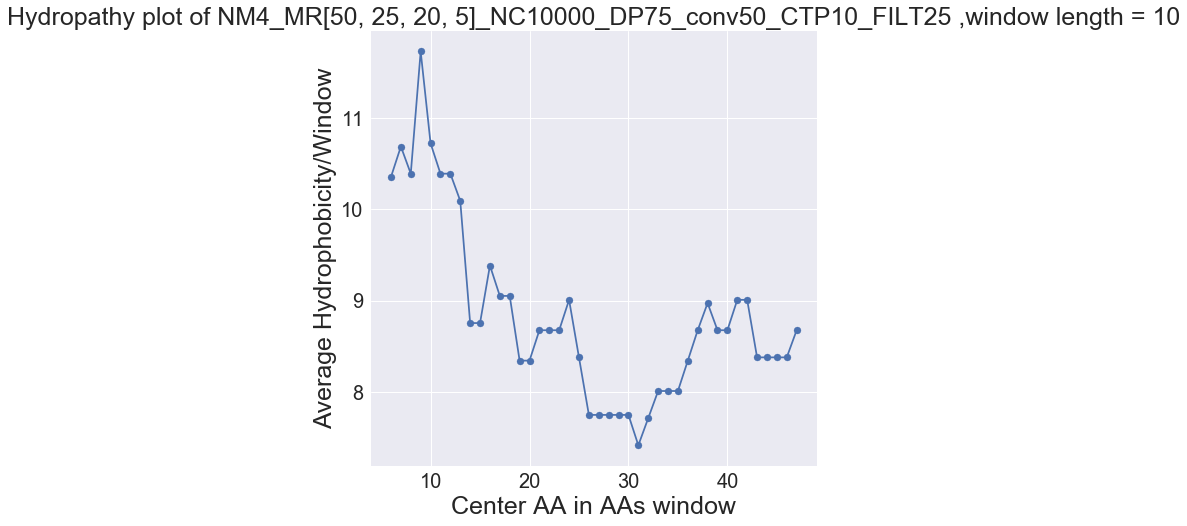

In [11]:
batch_num = 2
sequence_num = 1982

filename = csv_files[m].replace(path, '').replace('/', '').replace('.csv', '')
i = 0
for seq in tqdm_notebook(seqs[m]):
    if i == sequence_num:
        bins = translate(seq, HLBs)
        sliding_arrays = window(bins, WIN_LENGTH)
        pos_val = seg_analysis(sliding_arrays, WIN_LENGTH)
        win_plot(pos_val, filename, WIN_LENGTH)
    i = i + 1

In [14]:
#get HLB files of a particular window length
path = "outputs"
hlb_csv_files = []
for file in os.listdir(path):
    if file.endswith("HLB_%d.csv"% (int(window_len))):
        hlb_csv_files.append(os.path.join(path, file))
hlb_csv_files = sorted(hlb_csv_files)
print("Number of sequence files:", len(hlb_csv_files))
print(hlb_csv_files)

Number of sequence files: 9
['outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP100_conv50_CTP10_FILT25_HLB_10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP125_conv50_CTP10_FILT25_HLB_10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP150_conv50_CTP10_FILT25_HLB_10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP175_conv50_CTP10_FILT25_HLB_10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP200_conv50_CTP10_FILT25_HLB_10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP225_conv50_CTP10_FILT25_HLB_10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP250_conv50_CTP10_FILT25_HLB_10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP50_conv50_CTP10_FILT25_HLB_10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP75_conv50_CTP10_FILT25_HLB_10.csv']


rows size: 9865
cols size: 304


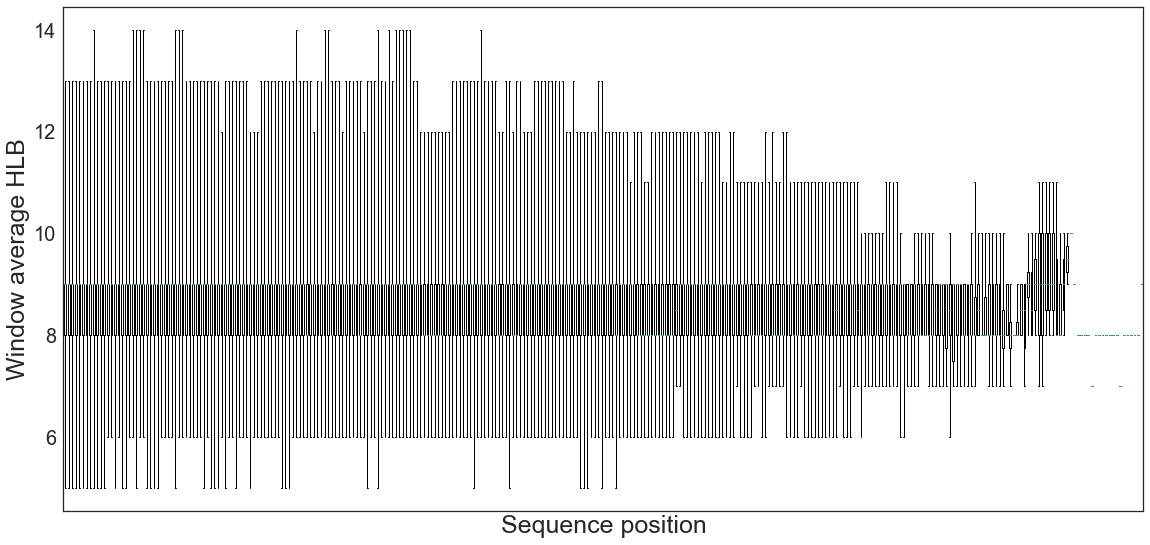

rows size: 9978
cols size: 334


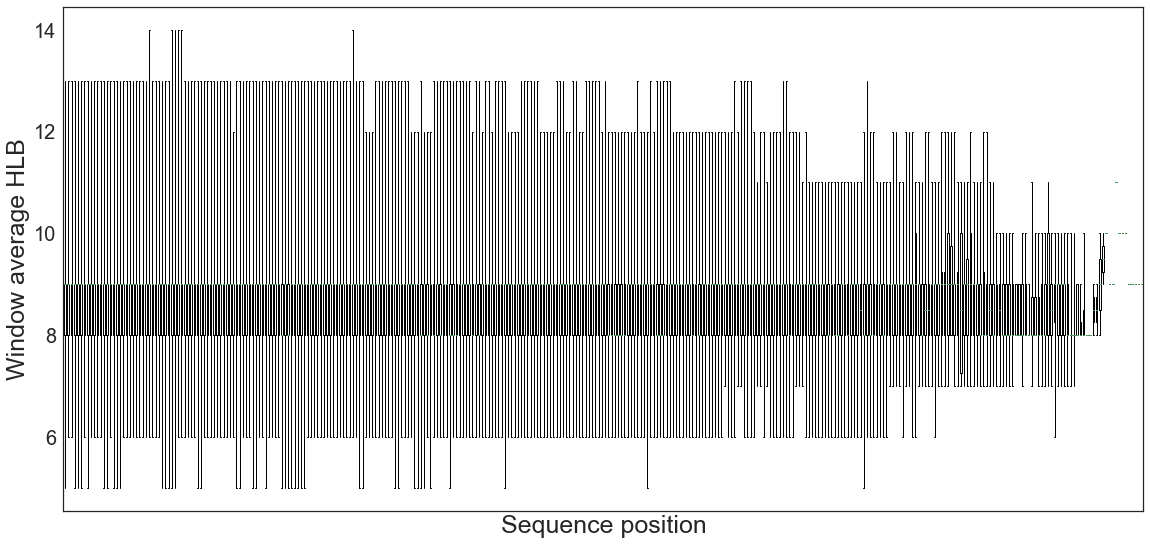

rows size: 9994
cols size: 403


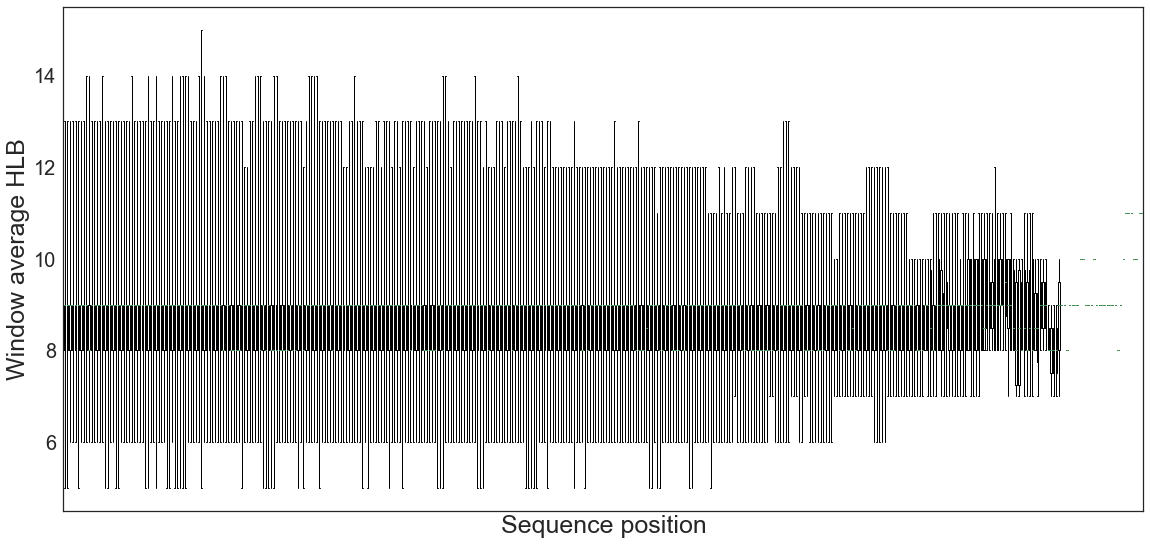

rows size: 9999
cols size: 433


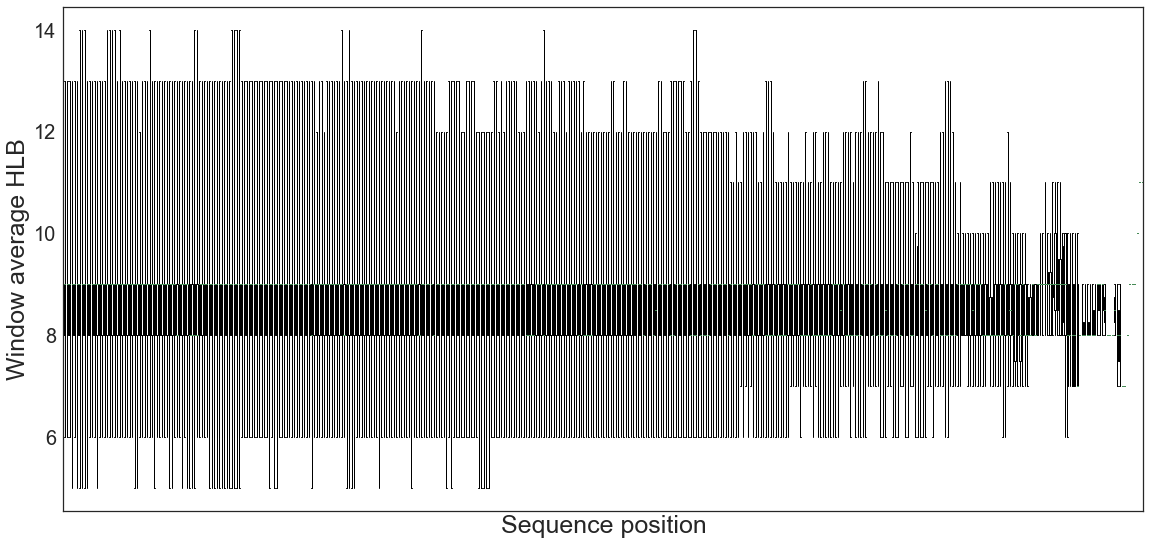

rows size: 10000
cols size: 515


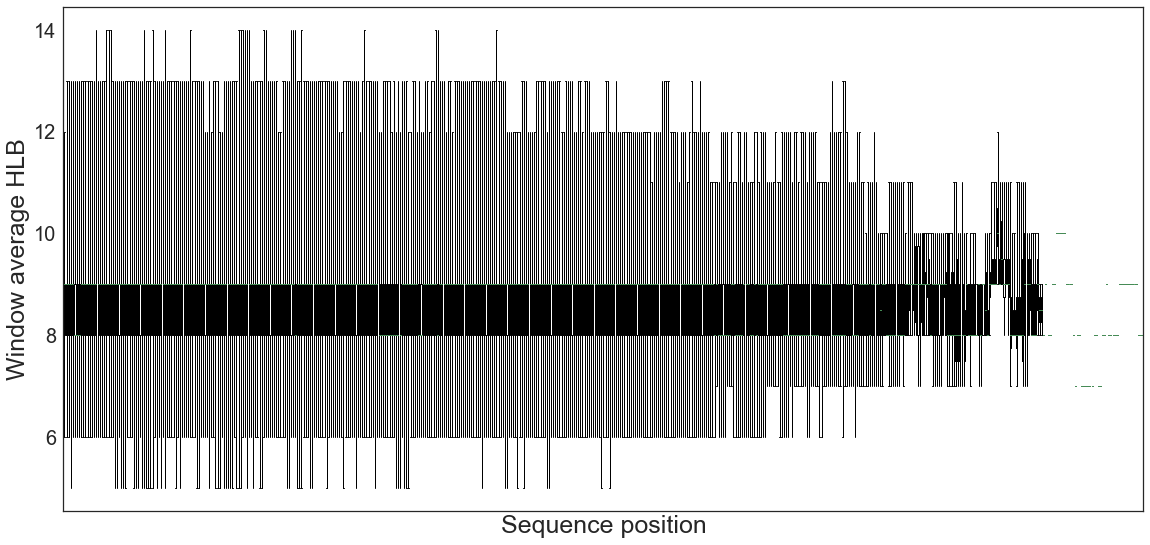

rows size: 9999
cols size: 521


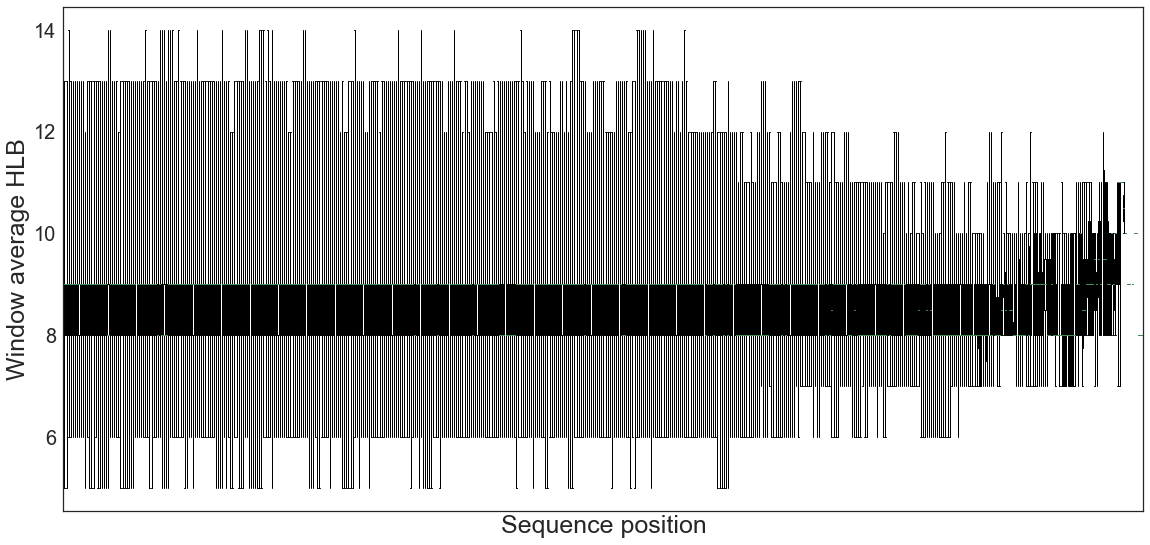

rows size: 10000
cols size: 552


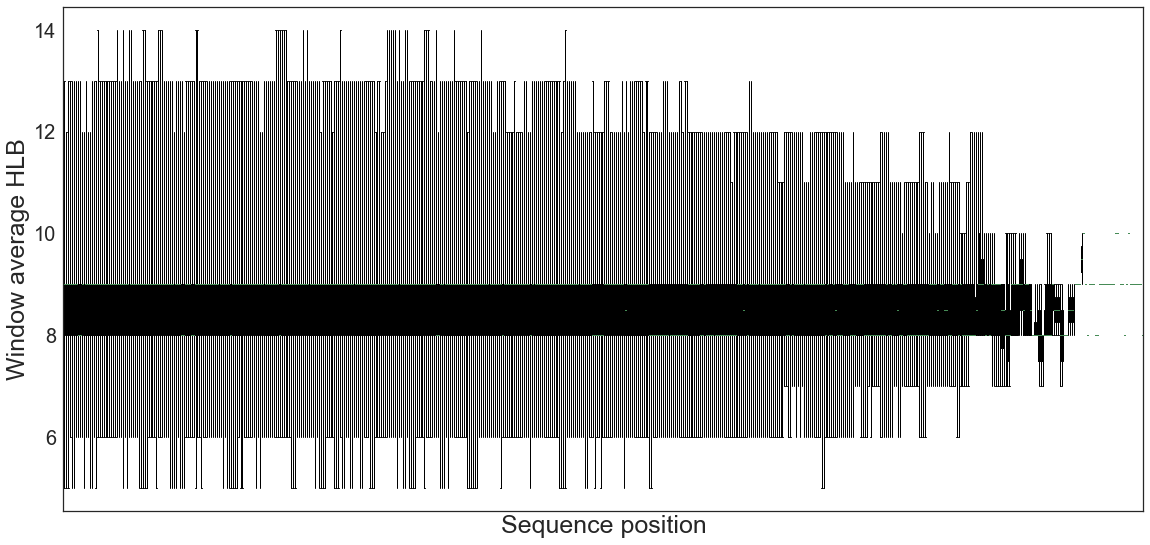

rows size: 7698
cols size: 238


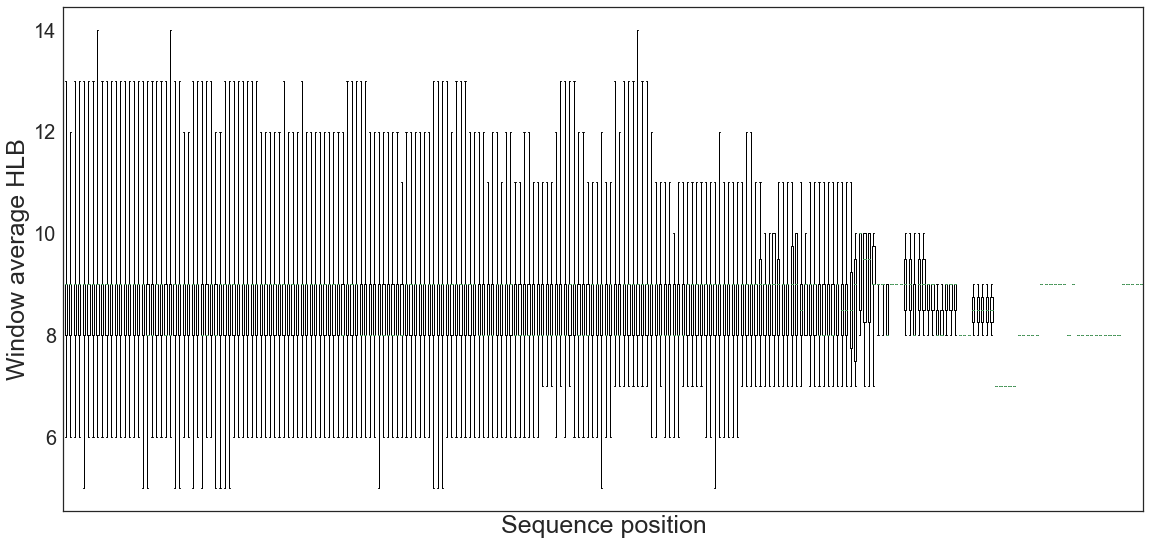

rows size: 9357
cols size: 249


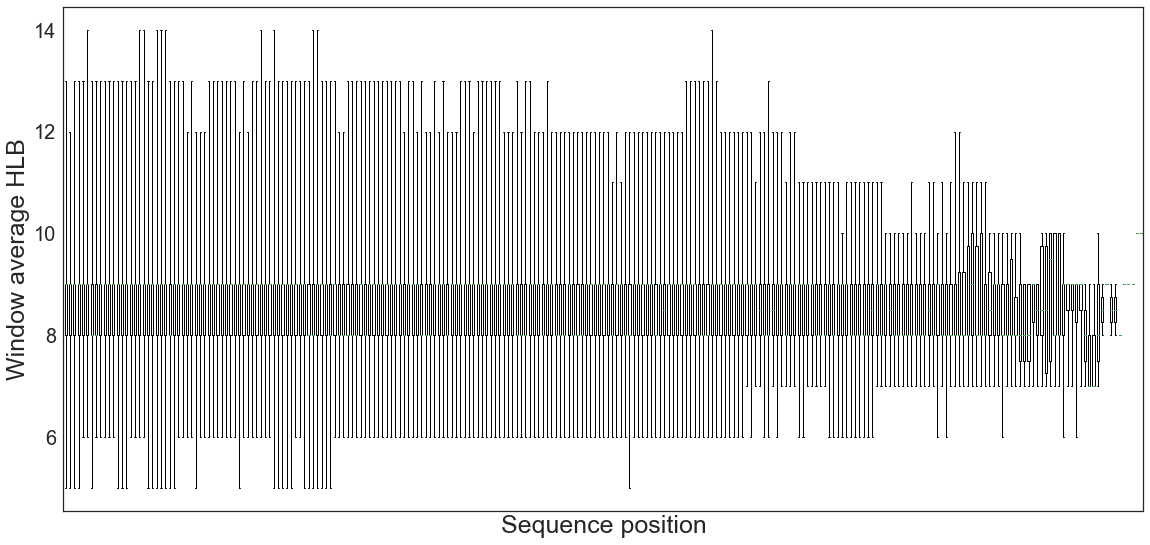

In [34]:
# read sliding window analysis csv files and convert to pd dataframes
dfs_hlb = []
seq_lens_hlb = []
#batch_ind = batch_no - 1

for m in range(len(hlb_csv_files)):
    seq = []
    row_size = []
    
    with open(hlb_csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            if i > 1:
                seq.append(lines)
                row_size.append(len(lines))
        df = pd.DataFrame(seq)
        dfs_hlb.append(df)
        seq_lens_hlb.append(row_size)


for batch_ind in range(len(hlb_csv_files)):

    rows_size = len(dfs_hlb[batch_ind])
    print("rows size:", rows_size)
    cols_size = len(dfs_hlb[batch_ind].columns)
    print("cols size:", cols_size)

    #Box Whisker Plot of Sliding Window Analaysis Data

    pos_data = list()
    for i in range(cols_size):
        datacol = [int(float((y_))) for y_ in dfs_hlb[batch_ind][i] if str(y_) != '']
        pos_data.append(datacol)

    fig = plt.figure(figsize =(15, 7))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.boxplot(pos_data, whis=(0,100))
    plt.xlabel("Sequence position")
    plt.ylabel("Window average HLB")
    plt.xticks([])
    #plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
    plt.show()
    